In [1]:
import matplotlib

In [2]:
# %matplotlib qt
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# import pylab as plt
import blimpy
from blimpy import Waterfall
from blimpy import calcload
import os
import glob
import numpy as np
import time
from scipy.stats import norm, kurtosis
import scipy
import numpy.ma as ma
import pandas as pd


In [2]:
from cosmic_flag_rfi_kurtosis.plotting_functions import plot_exkurt

ModuleNotFoundError: No module named 'analysis_functions'

In [24]:
%matplotlib inline

In [3]:
import sys
file_path = os.path.expanduser('~/nrao_summer_2023/cosmic-flag-rfi-kurtosis/cosmic_flag_rfi_kurtosis')
sys.path.insert(1, file_path)
# print(file_path[:20])
# from plotting_functions import plot_tavg_power

In [39]:
%matplotlib inline

In [18]:
fil_loc = os.path.expanduser('~/nrao_summer_2023/filterbank/*.fil')
file_list = glob.glob(fil_loc)

ml_list = []
name_index = fil_loc.rfind('/') + 1
for i, file in enumerate(file_list):
    ml = blimpy.calcload.calc_max_load(os.path.join(file))
    ml_list.append(ml)
    print(f'{ml} -- {file[name_index:]}')

11.0 -- band_test_AC_CO-beam0001.fil
9.0 -- band_test_AC_C512-beam0001.fil
11.0 -- Band_Test_BD_C0-beam0001.fil
11.0 -- band_test_AC_C32-beam0001.fil
7.0 -- band_test_GPU3_BD_C32-beam0001.fil
4.0 -- band_test_AC_C544-beam0001.fil
9.0 -- Band_Test_BD_C512-beam0001.fil


In [3]:
filfil = os.path.expanduser('/home/sofairj/nrao_summer_2023/filterbank/band_test_AC_C544-beam0001.fil')

In [4]:
t0 = time.time()
print('\nGenerating waterfall object...')
ml = blimpy.calcload.calc_max_load(filfil)
wf = Waterfall(os.path.normpath(filfil), max_load = ml)
t1 = time.time()
print(f'Done. Elapsed time: {t1 - t0}')


Generating waterfall object...
Done. Elapsed time: 6.636639833450317


In [5]:
wf.info()


--- File Info ---
      machine_id :                                0
    telescope_id :                               -1
         src_raj :                 4:09:22.00873993
         src_dej :                12:17:39.84749624
        az_start :              6.927632722041e-310
        za_start :             4.6890767235416e-310
       data_type :                                1
            fch1 :           2540.4999961853027 MHz
            foff :           -7.62939453125e-06 MHz
          nchans :                          4194304
          nbeams :                                2
           ibeam :                                1
           nbits :                               32
   tstart (ISOT) :          2023-05-10T22:08:42.502
    tstart (MJD) :               60074.922714145854
           tsamp :                         0.131072
            nifs :                                1
     barycentric :                                1
   pulsarcentric :                           

In [ ]:

t0=time.time()
print(f'Start time: {time.strftime("%H:%M:%S", time.localtime())}')

# water0 = Waterfall(os.path.normpath(file_list[0]), max_load = ml_list[0])
water1 = Waterfall(os.path.normpath(file_list[1]), max_load = ml_list[1])
water2 = Waterfall(os.path.normpath(file_list[2]), max_load = ml_list[2])
water3 = Waterfall(os.path.normpath(file_list[3]), max_load = ml_list[3])
water4 = Waterfall(os.path.normpath(file_list[4]), max_load = ml_list[4])
# water5 = Waterfall(os.path.normpath(file_list[5]), max_load = ml_list[5])
# water6 = Waterfall(os.path.normpath(file_list[6]), max_load = ml_list[6])

# water_list = [water0, water1, water2, water3, water4, water5, water6]
water_list = [0, water1, water2, water3, water4, 0, 0]
# print(water_list)

t1 = time.time()
print(f'Elapsed time: {t1 - t0}')



In [21]:
f_min = np.floor(np.amin(wf.get_freqs()))
f_max = np.ceil(np.amax(wf.get_freqs()))

print(f_min, f_max)


2508.0 2541.0


In [22]:
plot_tavg_power(wf, n_divs=256, threshold=5, f_start=f_min, f_stop=f_max, p_start = 0, p_stop = 2*10**10)

NameError: name 'plot_tavg_power' is not defined

In [8]:
freq_borders = []
for i, wf in enumerate(water_list):
    if wf != 0:
        freq_borders.append({np.amin(wf.get_freqs()) : i})
print(freq_borders)
# np.set_printoptions(threshold=50)
# print(np.sort(freq_borders, axis=0))

[{3500.5000038146973: 1}, {2476.5000038146973: 2}, {2988.5000038146973: 3}, {3020.5000038146973: 4}]


In [7]:
for i, wf in enumerate(water_list):
    if (i+1 > 0) & (i+1 < 5):
        exec(f'f_min{i+1} = (np.amin(water{i+1}.get_freqs()))')
        exec(f'f_max{i+1} = (np.amax(water{i+1}.get_freqs()))')
        exec(f'print(f_min{i+1}, f_max{i+1})')
# 640 channels (not true for every file!)
# ~4.2 M fine frequency channels (seems to be true for every file I've worked with thus far!)

3500.5000038146973 3532.4999961853027
2476.5000038146973 2508.4999961853027
2988.5000038146973 3020.4999961853027
3020.5000038146973 3052.4999961853027


In [8]:
def get_tavg_kurtosis(wf_in, n_divs=256):
    # This function grabs the kurtosis of channels of a specified size for a blimpy waterfall object
    
    # wf_in: Specified blimpy waterfall object
    # n_divs: Number of divisions to break wf_in into
        # 32 is the correct number of channels to break a waterfall into assuming the frequency range
        # of the waterfall is 32 MHz
        
    np.set_printoptions(threshold=4)

    # Get power and frequency in increasing order
    if wf_in.header['foff'] < 0:
        pows_flipped = np.flip(wf_in.data)
        freqs_flipped = wf_in.get_freqs()[::-1]
    
    # So...
    # pows_flipped is all of the powers in increasing order,
    # freqs_flipped is all of the frequencies in increasing order

    # Time-average the power
    pows_mean_flipped = np.mean(pows_flipped, axis=0)[0]    

    # Split frequency and time-averaged power into n_divs channels
    freqs = np.array_split(freqs_flipped, n_divs)
    pows_mean = np.array_split(pows_mean_flipped, n_divs)
    
    # Get kurtosis of all channels
    kurts_list = []
    
    for i, division in enumerate(pows_mean):
        kurts_list.append(kurtosis(division/(10**9))) # Rescaling data so that kurtosis != inf ever
    
    kurts = np.array(kurts_list, dtype=np.float64)
    
    # Check to see if any of the kurtoses are infinite
    if np.any(np.isfinite(kurts)) == False:
        print(f'Infinite kurtoses located at indices {np.where(np.isfinite(kurts) == False)}')
    else:
        print('No infinite kurtoses found')

    # Binning frequencies such that the labeled frequency is the bottom of the bin
    # i.e., if chnl[0] is 2010 MHz and each channel is 1 MHz, then the bin from 2010 MHz to 2010.99 MHz will have
    # a value of "2010"
    bins = []
    for chnl in freqs:
        bins.append(chnl[0])

    # bins: All frequency bins for the frequency range of the waterfall
    # kurts: Kurtosis of all frequency bins
    # pows_mean_flipped: All time-averaged power (not split into bins)
    return bins, kurts, pows_mean_flipped

In [9]:
def plot_tavg_kurtosis(wf_in, n_divs=256):
    # This function plots the kurtosis of the time-averaged power spectrum.
    # For info on inputs, see get_tavg_kurtosis() function definition.
    
    # Get bin and kurtosis information
    bins, kurts, pows_mean = get_tavg_kurtosis(wf_in, n_divs)
    
    # Plot kurtosis vs. frequency
    fig, ax = plt.subplots()
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Kurtosis')
    
    ax.plot(bins, kurts, '.', c='black')

In [10]:
def get_mask_kurtosis(wf_in, n_divs=256, threshold=50):
    # This function flags bins with high kurtosis (i.e., heavy RFI) and returns the necessary information about
    # these bins.
    # wf_in: See get_tavg_kurtosis() function definition
    # n_divs: See get_tavg_kurtosis() function definition
    # threshold: Minimum kurtosis for a channel to be flagged as 'RFI-heavy'
    
    
    # Get bin and kurtosis information
    bins, kurts, pows_mean = get_tavg_kurtosis(wf_in, n_divs)
    
    # masked_kurts is an array that has all channels with |kurtosis| > threshold masked out
    masked_kurts = ma.masked_where(np.abs(kurts) > threshold, kurts)
    bin_mask = ma.getmask(masked_kurts)
    
    # flagged_bins is an array that has the frequencies of the channels with kurtosis > threshold NOT masked out
    # flagged_kurts masks the opposite elements as masked_kurts (i.e., it contains all of the kurtoses of the
    # high RFI channels)
    flagged_bins = ma.masked_array(bins, mask=~bin_mask)
    flagged_kurts = ma.masked_array(kurts, mask=~bin_mask)
    
    # The reason I am no longer using ma.count(masked_array) is because there can be an error where masked elements
    # are converted to NaNs.
    print(f'{len(np.where(bin_mask == True)[0])} out of {n_divs} channels flagged as having substantial RFI')
    
    # TODO: Grab mask that contains the frequencies with high RFI, not the frequency *bins*!
    # Get frequency in increasing order, first
    if wf_in.header['foff'] < 0:
        freqs_flipped = wf_in.get_freqs()[::-1]
        freqs = ma.masked_array(freqs_flipped)
    
    # Bin width...?
    # There are 7 Hz in between each entry of freqs, and 32 MHz total
    # Given a total of 4194304 elements in freqs, if there are 256 bins, then each bin spans 16384 elements
    # If each bin spans 16384 elements, then it spans 125 kHz (125 kHz * 256 = 32 MHz)
    
    full_freq_range = freqs[-1] - freqs[0]
    bin_width = bin_width = full_freq_range / n_divs # This is the bin width in terms of MHz
    
    bin_width_elements = int(np.floor(len(freqs) / n_divs)) # This is the bin width in terms of the number of elements in freqs
    
#     print(f'bin width: {bin_width}')
    
    masked_freqs = ma.masked_array(freqs)
    
    for rfi_bin in flagged_bins:
        try:
            # Get the frequency indices of the masked frequency bins and put them in a list
            xmin = np.where(freqs == rfi_bin)[0][0]
            xmax = xmin + bin_width_elements
            masking_indices = np.arange(xmin, xmax)
            
            # Create a masked array that masks the indices of the high RFI bins
            masked_freqs[masking_indices] = ma.masked
            freq_mask = ma.getmask(masked_freqs)
        except:
            pass
    
    # Summary of returned variables:
    # flagged_bins: Channels with high kurtosis (i.e., high RFI)
    # flagged_kurts: Kurtosis of each channel that was flagged as having high RFI
    # masked_kurts: Kurtosis of all 'clean' (low RFI) channels with high RFI channels masked out
    # masked_freqs: List of all frequencies with high RFI channels masked out
    # bin_mask: The mask used to generate masked_kurts -- Masks the frequency *bins*
    # freq_mask: A mask to be used to block out the *actual* frequencies, rather than the frequency *bins*
    return flagged_bins, flagged_kurts, masked_kurts, masked_freqs, bin_mask, freq_mask

In [11]:
flagged_bins1, flagged_kurts1, masked_kurts1, masked_freqs1, bin_mask1, freq_mask1 = get_mask_kurtosis(water1, threshold=1.25)
flagged_bins2, flagged_kurts2, masked_kurts2, masked_freqs2, bin_mask2, freq_mask2 = get_mask_kurtosis(water2, threshold=1.5)
flagged_bins3, flagged_kurts3, masked_kurts3, masked_freqs3, bin_mask3, freq_mask3 = get_mask_kurtosis(water3, threshold=4)
flagged_bins4, flagged_kurts4, masked_kurts4, masked_freqs4, bin_mask4, freq_mask4 = get_mask_kurtosis(water4, threshold=1.25)

No infinite kurtoses found
11 out of 256 channels flagged as having substantial RFI
No infinite kurtoses found
59 out of 256 channels flagged as having substantial RFI
No infinite kurtoses found
52 out of 256 channels flagged as having substantial RFI
No infinite kurtoses found
9 out of 256 channels flagged as having substantial RFI


In [172]:
print(len(flagged_bins1), flagged_bins1)

256 [3500.5000038146973 3500.6250038146973 3500.7500038146973 ...
 3532.1250038146973 -- 3532.3750038146973]


In [12]:
bins1, kurts1, pows_mean1 = get_tavg_kurtosis(water1)
bins2, kurts2, pows_mean2 = get_tavg_kurtosis(water2)
bins3, kurts3, pows_mean3 = get_tavg_kurtosis(water3)
bins4, kurts4, pows_mean4 = get_tavg_kurtosis(water4)

No infinite kurtoses found
No infinite kurtoses found
No infinite kurtoses found
No infinite kurtoses found


In [38]:
export_kurtoses = np.array([np.asarray(kurts1), np.asarray(kurts2), np.asarray(kurts3), np.asarray(kurts4)]).flatten()
print(len(export_kurtoses))
export_pows = np.array([np.asarray(pows_mean1), np.asarray(pows_mean2), np.asarray(pows_mean3), np.asarray(pows_mean4)]).flatten()
print(len(export_pows))

flagged_bins1 = ma.filled(flagged_bins1, fill_value=np.NaN)
flagged_bins2 = ma.filled(flagged_bins2, fill_value=np.NaN)
flagged_bins3 = ma.filled(flagged_bins3, fill_value=np.NaN)
flagged_bins4 = ma.filled(flagged_bins4, fill_value=np.NaN)

print(flagged_bins1)

export_binbots = np.concatenate([flagged_bins1, flagged_bins2, flagged_bins3, flagged_bins4]).flatten()
print(f'{len(export_binbots)}, {type(export_binbots)}, {np.count_nonzero(~np.isnan(export_binbots))}, {export_binbots}')

1024
16777216
[3500.50000381 3500.62500381 3500.75000381 ... 3532.12500381           nan
 3532.37500381]
1024, <class 'numpy.ndarray'>, 131, [3500.50000381 3500.62500381 3500.75000381 ... 3052.12500381 3052.25000381
 3052.37500381]


In [37]:
export_bin_width = (np.amax(water1.get_freqs()) - np.amin(water1.get_freqs()))/256
print(export_bin_width)

export_bintops = export_binbots + export_bin_width
print(len(export_bintops), export_bintops)


export_freqs = np.array([np.asarray(water1.get_freqs()), np.asarray(water2.get_freqs()), np.asarray(water3.get_freqs()), np.asarray(water4.get_freqs())]).flatten()
print(len(export_freqs), export_freqs)

export_masked_freqs = np.array([np.asarray(masked_freqs1), np.asarray(masked_freqs2), np.asarray(masked_freqs3), np.asarray(masked_freqs4)]).flatten()
print(len(export_masked_freqs), export_masked_freqs)

0.12499997019767761
1024 [3500.62500378 3500.75000378 3500.87500378 ... 3052.25000378 3052.37500378
 3052.50000378]
16777216 [3532.49999619 3532.49998856 3532.49998093 ... 3020.50001907 3020.50001144
 3020.50000381]
16777216 [3500.50000381 3500.50001144 3500.50001907 ... 3052.49998093 3052.49998856
 3052.49999619]


In [1]:
arr1 = np.arange(1,5)
arr2 = np.arange(5,16)
arr3 = np.arange(16,18)
arr4 = np.arange(18,22)

test_data = {'col1':arr1, 'col2':arr2, 'col3':arr3, 'col4':arr4}

test_df = pd.DataFrame(test_data)
print(test_df)

In [44]:
export_masked_freqs_df = pd.DataFrame(data=export_masked_freqs, columns=['masked_freqs'])

export_binbots_df = pd.DataFrame(data=export_binbots, columns=['rfi_freq_bin_bots'])
export_bintops_df = pd.DataFrame(data=export_bintops, columns=['rfi_freq_bin_tops'])
pre_export_bins = pd.concat([export_binbots_df, export_bintops_df], axis=1)

bins_export_df = pre_export_bins.sort_values(by=['rfi_freq_bin_bots'])
bins_export_df = pre_export_bins.sort_values(by=['rfi_freq_bin_tops']).reset_index(drop=True)

print(bins_export_df)
print(bins_export_df.count())

      rfi_freq_bin_bots  rfi_freq_bin_tops
0           2476.500004        2476.625004
1           2476.625004        2476.750004
2           2476.750004        2476.875004
3           2476.875004        2477.000004
4           2477.000004        2477.125004
...                 ...                ...
1019                NaN                NaN
1020                NaN                NaN
1021                NaN                NaN
1022                NaN                NaN
1023                NaN                NaN

[1024 rows x 2 columns]
rfi_freq_bin_bots    131
rfi_freq_bin_tops    131
dtype: int64


In [45]:
bins_export_df.to_csv('/lustre/aoc/students/jsofair/prelim_kurt_bins.csv', index=False)

In [203]:
data = {'all_freqs':export_freqs,
        'masked_freqs':export_masked_freqs,
        'freq_bin_bots':export_binbots,
        'freq_bin_tops':export_bintops
       }

pre_export_freqs = pd.concat([export_freqs_df, export_masked_freqs_df], axis=1)
export_freqs_df = pd.DataFrame(data=export_freqs, columns=['all_freqs'])


freqs_export_df = pre_export_freqs.sort_values(by=['all_freqs'])



# columns=['all_freqs','masked_freqs','freq_bin_bots','freq_bin_tops']
freqs_export_df.to_csv('/lustre/aoc/students/jsofair/prelim_kurt_freqs.csv', index=False)

In [29]:
print(f'{export_df.count()}, {ma.count(masked_freqs)}')

0    4014080
dtype: int64, 4014080


In [1]:
testarr = np.arange(0,4194304)
test_masked_arr = ma.masked_array(testarr, freq_mask)
test_freqs_masked = ma.masked_array(water0.get_freqs(), mask=freq_mask)
print(np.shape(water0.get_freqs()))
print(test_masked_arr)
print(test_freqs_masked)
print(ma.count(test_freqs_masked))

In [154]:
def plot_mask_kurtosis(wf_in, n_divs=256, threshold=50, unfiltered=True, clean_chnls=True, rfi=False,
                      f_start=0, f_stop=0, k_start=0, k_stop=0):
    # This function plots the kurtosis of each frequency channel for a specified waterfall object.
    # wf_in: See get_tavg_kurtosis() function definition
    # n_divs: See get_tavg_kurtosis() function definition
    # threshold: See get_mask_kurtosis() function definition
    # unfiltered: If true, plot the data before any RFI filtering has occurred
    # clean_chnls: If true, plot the data after RFI has been filtered out
    # rfi: If true, plot the channels that have been marked as RFI
    
    bins, kurts, pows_mean = get_tavg_kurtosis(wf_in, n_divs)
    flagged_bins, flagged_kurts, masked_kurts, masked_freqs, bin_mask, freq_mask = get_mask_kurtosis(wf_in, n_divs, threshold)
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Kurtosis')
    
    if unfiltered:
        ax.plot(bins, kurts, 'o', c='black', label='Unfiltered data') # Color is a nice black
    if clean_chnls:
        ax.plot(bins, masked_kurts, '.', c='#43cc5c', label='Clean channels') # Color is a nice green
    if rfi:
        ax.plot(flagged_bins, flagged_kurts, '.', c='red', label='Heavy RFI') # Color is a nice red
    
    if np.any([f_start, f_stop, k_start, k_stop]) != 0:
        ax.set_xlim(f_start, f_stop)
        ax.set_ylim(k_start, k_stop)
    
        ax.legend(fancybox=True,shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=3)
    else:
        ax.legend(fancybox=True,shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=3)

In [155]:
def plot_tavg_powertemp(wf_in,
                    f_start=0, f_stop=6000,
                    p_start=0, p_stop=5*10**10, n_divs=256, threshold=50,
                    show_filtered_bins=True):
    # Plot the time-averaged power spectrum for a given blimpy waterfall object
    # wf: The desired input waterfall object
    # t: The integration number
    # f_start: Lower bound for frequency (horizontal) axis
    # f_stop: Upper bound for frequency (horizontal) axis
    # p_start: Lower bound for time-averaged power (veritcal) axis
    # p_start: Lower bound for time-averaged power (veritcal) axis
    # show_filtered: If true, draw a red box where high RFI channels are

    # Time average the power
    wf_pwr_mean_arr = np.mean(wf_in.data, axis=0)
    wf_pwr_mean = wf_pwr_mean_arr[0]
   
    # Plot time-averaged power
    fig, ax = plt.subplots()
    
    ax.set_xlim(f_start, f_stop)
    ax.set_ylim(p_start, p_stop)
    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Time-Averaged Power (Counts)')

    ax.plot(wf_in.get_freqs(), wf_pwr_mean, label='Time-averaged power spectrum', c='#1f1f1f')

    # Grab info for RFI masking
    bins, kurts, pows_mean = get_tavg_kurtosis(wf_in, n_divs)
    flagged_bins, flagged_kurts, masked_kurts, masked_freqs, bin_mask, freq_mask = get_mask_kurtosis(wf_in, n_divs, threshold)

    # Plot frequency bins that were flagged as RFI
    if show_filtered_bins == True:
        full_freq_range = np.amax(wf_in.get_freqs()) - np.amin(wf_in.get_freqs())
        bin_width = full_freq_range / n_divs

        for rfi_bin in flagged_bins:
            xmin = rfi_bin
            xmax = rfi_bin + bin_width
            flagged_line = plt.axvspan(xmin=xmin, xmax=xmax, ymin=0, ymax=1, color='red', alpha=0.5)

        flagged_line.set_label('RFI-flagged channels')
        ax.legend(fancybox=True,shadow=True, loc='lower center', bbox_to_anchor=(1, 1), ncols=1)
    else:
        ax.legend(fancybox=True,shadow=True, loc='lower center', bbox_to_anchor=(1, 1), ncols=1)
        

In [119]:
thrsh = 1.25
ndivs = 256

No infinite kurtoses found
Getting time averaged kurtosis...
No infinite kurtoses found
9 out of 256 channels flagged as having substantial RFI
Done getting time averaged kurtosis (2.3288514614105225 s elapsed)
Getting masks...
Done getting masks (3.235891580581665 s elapsed)


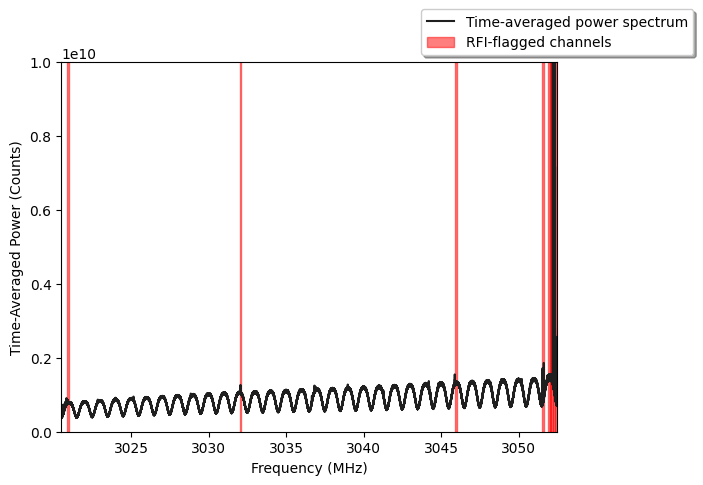

In [123]:
plot_tavg_powertemp(water4, n_divs=ndivs, threshold=thrsh,
                    f_start=f_min4, f_stop=f_max4, p_start=0, p_stop=1*10**10, 
                    show_filtered_bins=True)

130 out of 512 channels flagged as having substantial RFI


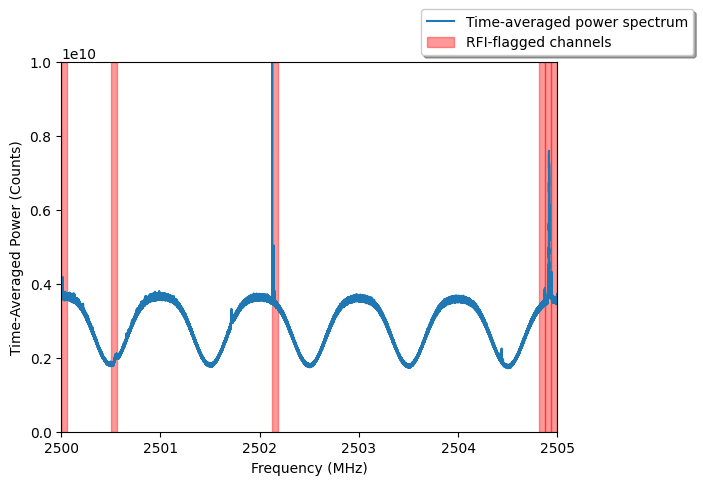

In [21]:
plot_tavg_powertemp(water2, n_divs=512, threshold=1.25,
                    f_start=2500, f_stop=2505, p_start=0, p_stop=1*10**10, 
                    show_filtered_bins=True)

In [63]:
water5.plot_waterfall(f_start=2015, f_stop=2020)

In [53]:
bins, kurts, pows_mean = get_tavg_kurtosis(water2, n_divs=256)
for i in bins:
#     print(i)
    if i > 2483.625:
        if i < 2490.9:
#             pass
            print(bins.index(i), i)

57 2483.6250038146973
58 2483.7500038146973
59 2483.8750038146973
60 2484.0000038146973
61 2484.1250038146973
62 2484.2500038146973
63 2484.3750038146973
64 2484.5000038146973
65 2484.6250038146973
66 2484.7500038146973
67 2484.8750038146973
68 2485.0000038146973
69 2485.1250038146973
70 2485.2500038146973
71 2485.3750038146973
72 2485.5000038146973
73 2485.6250038146973
74 2485.7500038146973
75 2485.8750038146973
76 2486.0000038146973
77 2486.1250038146973
78 2486.2500038146973
79 2486.3750038146973
80 2486.5000038146973
81 2486.6250038146973
82 2486.7500038146973
83 2486.8750038146973
84 2487.0000038146973
85 2487.1250038146973
86 2487.2500038146973
87 2487.3750038146973
88 2487.5000038146973
89 2487.6250038146973
90 2487.7500038146973
91 2487.8750038146973
92 2488.0000038146973
93 2488.1250038146973
94 2488.2500038146973
95 2488.3750038146973
96 2488.5000038146973
97 2488.6250038146973
98 2488.7500038146973
99 2488.8750038146973
100 2489.0000038146973
101 2489.1250038146973
102 2489

In [13]:
values = np.array([1,2,3,4,5])
indices = np.array([0,1,3])

masked_values = ma.masked_array(values)
masked_values[indices] = ma.masked
print(masked_values)

# we want it so that the elements in arr1 that match the elements in arr2 are masked



# print(maskiee)
# np.arange(500, 505)

[-- -- 3 -- 5]


array([500, 501, 502, 503, 504])

In [1]:
x = np.arange(1,6)
maskie = x>2

print(~maskie)

In [14]:
get_mask_kurtosis(water0, n_divs=256)
print()

# How many frequencies should be masked?

165 out of 256 channels flagged as having substantial RFI
bin width: 0.12499997019767761
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384
16384

240 out of 256 channels flagged as having substantial RFI


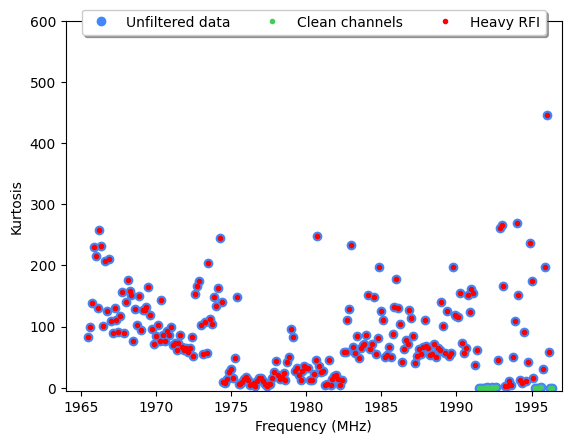

In [23]:
plot_mask_kurtosis(water2, n_divs=ndivs, threshold=thrsh, rfi=True,
                  f_start=f_min, f_stop=f_max, k_start=-5, k_stop=600)

In [61]:
flagged_bins, flagged_kurts, masked_kurts, bin_mask, freq_mask = get_mask_kurtosis(water2, n_divs=ndivs, threshold=thrsh)

print(mask)

240 out of 256 channels flagged as having substantial RFI
[ True  True  True ...  True False False]


In [57]:
bins, kurts, pows_mean = get_tavg_kurtosis(water2, n_divs=256)
np.set_printoptions(threshold=sys.maxsize, suppress=True)

for i in kurts[57:118]:
    if np.abs(i) < 1:
        print(i)
# print(kurts[57:118])

-0.9441275739966115
0.2356335251804067
-0.24289774071627557
-0.3255770378777201
-0.4819748895491336
-0.9294241821704308
-0.6420960059070691
-0.11927614867614666
0.16031438953312138
-0.1565957051809339
-0.35009353343198324
-0.4261962086483675
-0.6534365774420685
-0.19175884404992827
-0.4302306801260549
-0.6522846519261498
-0.7260550132783368
-0.8072657713252278
-0.2734562220529706
-0.7860554616859523
-0.13569532957596886
-0.2968214882051461
-0.8974747875381879
-0.20118763156430397
-0.45740783601655277
-0.424624300919056
-0.9980575318876475
-0.7798652113475772
-0.04860401965382222
0.00882420723571542
-0.47329790152901285
-0.09298843571814963
-0.9425098327586099
-0.9286223569053575
-0.8083614917819548
-0.9448517829596792
-0.1368367031430111
-0.04678724865417205
-0.8750630252396054
-0.21474850128728118
-0.08696885950453837


In [55]:
bins, kurts, pows_mean= get_tavg_kurtosis(water2, n_divs=256)
flagged_bins, flagged_kurts, masked_kurts, bin_mask, freq_mask = get_mask_kurtosis(water2, n_divs=ndivs, threshold=thrsh)
np.set_printoptions(threshold=sys.maxsize, suppress=True)

rfi_flagged_bins = []
clean_bins = []


for i in ma.nonzero(flagged_kurts)[0]:
    rfi_flagged_bins.append(flagged_kurts[i])

# print(masked_kurts[ma.nonzero(masked_kurts)[0][0]])
# print(ma.nonzero(masked_kurts)[0])
for j in ma.nonzero(masked_kurts)[0]:
    clean_bins.append(masked_kurts[j])

print(f'rfi bins ({len(rfi_flagged_bins)}), std: {np.std(kurts)}): {np.sort(rfi_flagged_bins)}\n\nClean bins ({len(clean_bins)}): {np.sort(clean_bins)}\n\nAll bins (kurt) ({len(kurts)}): {np.sort(kurts)}\n\nAll bins (freq): {np.sort(bins)}')

64 out of 256 channels flagged as having substantial RFI
rfi bins (64), std: 2283.6841365601363): [   -1.49447178    -1.43665892    -1.42848344    -1.30072005
     1.36723619     1.77765499     1.95520294     1.99599226
     2.69837153     2.77565842     7.45194075     9.15578843
    12.13500016    34.08678727    53.79489517    56.06106366
    58.8111758     62.21383076    71.23381903    73.59801816
    77.0791839     77.4582707     79.15564534    82.84868186
    82.9093589     84.27472784    88.12145303    92.5499934
    96.20952554   100.51537048   112.10573374   116.29790198
   123.1146959    137.56464516   137.99460361   145.47226332
   147.7016066    149.17771718   149.27834244   152.92054149
   154.62777942   155.68795645   161.78472667   161.80417559
   167.90087146   173.5330335    176.94288065   178.86000016
   203.19307854   205.33115996   213.13715848   222.13435578
   276.43721047   329.37764649  1017.144765    7592.36995261
  8344.13568248  8679.41036745  9316.69992882  95